# Project Introduction

#### The goal of this project is to create a model that can successfully take a real photo as input, and transform the style to look more like a Monet painting. This is a good example of 'Style Transfer' which GANs are very good at learning to do. We'll use a CycleGAN implementation to accomplish this task. A lot of this process was adapted from [Amy Jang's CycleGAN tutorial notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial), with some modifications to the architecture

In [1]:
import PIL
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.initializers import RandomNormal

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

import os
os.listdir('/kaggle/input/gan-getting-started')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: 
Number of replicas: 1
2.17.1


['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']

# Load and Explore the Data

#### Load the data -- the files are `.tfrec` extensions, which means one file can contain multiple images' data, that's why we only have 5 records for the 300 image Monet set

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


#### Next we'll extract the images. They are already the correct size, but need to be set to 3-channel data (R,G,B) and rescaled from their original [0, 256) range to [-1, 1) for easier processing. We also only need the image data itself, not any of the other info, so we'll discard that

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

#### Let's visualize a few images from each set

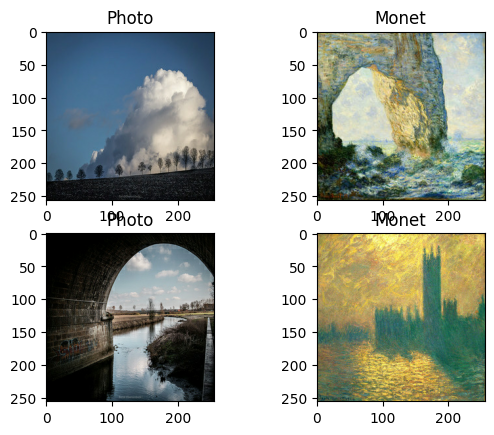

In [5]:
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)
example_monet1 = next(monet_iter)
example_photo1 = next(photo_iter)
example_monet2 = next(monet_iter)
example_photo2 = next(photo_iter)

plt.subplot(221)
plt.title('Photo')
plt.imshow(example_photo1[0] * 0.5 + 0.5)

plt.subplot(222)
plt.title('Monet')
plt.imshow(example_monet1[0] * 0.5 + 0.5)

plt.subplot(223)
plt.title('Photo')
plt.imshow(example_photo2[0] * 0.5 + 0.5)

plt.subplot(224)
plt.title('Monet')
plt.imshow(example_monet2[0] * 0.5 + 0.5)

# Building the Model

## Generator

#### For this implementation of CycleGAN, we'll use UNET in our Generator. UNET utilizes a series of "downsampling" CNN layers that shrink the dimensions of the input. Once the input has been downsampled sufficiently, it goes through an "upsample" layer that uses a transposed CNN layer to increase the dimensions of the input. These layers also have skip connections to help reduce vanishing/exploding gradients and reduce overfitting. 

#### This is where we diverge from Amy Jang's tutorial. I'm implementing a version of UNET that is closer to the original paper. Each upsampling/downsampling layer will have multiple convolution layers + max pooling in it, rather than her implementation which uses one convolution per up/downsample layer

#### The end result is a generator with fewer up/downsample layers, but more convolutions in total. If time permits, we'll compare this to her original implementation as well

In [6]:
class ResizeLayer(keras.Layer):
    def call(self, x, in_size):
        return tf.image.resize(x, size=(in_size[1], in_size[2]))

In [7]:
def downsample_layer(filters, size, apply_instancenorm=True):
    kernel_init = RandomNormal(mean=0.0, stddev=0.05)
    gamma_init = RandomNormal(mean=0.0, stddev=0.05)

    # Convolution 1 + activation
    # disabling bias terms since we have a deep network
    layer = layers.Conv2D(filters, (3,3), padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(inputs)
    layer = layers.LeakyReLU()(layer)

    # Convolution 2 + activation
    layer = layers.Conv2D(filters, (3,3), padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(layer)
    layer = layers.LeakyReLU()(layer)

    # Max Pool and output
    layer = layers.MaxPool2D(pool_size=(2,2), strides=2)(layer)

    return layer


def upsample_layer(filters, size, apply_dropout=False):
    kernel_init = RandomNormal(mean=0.0, stddev=0.05)
    gamma_init = RandomNormal(mean=0.0, stddev=0.05)

    # First, upsample with a 2x2 filter
    layer = layers.Conv2DTranspose(filters, (3,3), strides=2,
                                    padding='same',
                                    kernel_initializer=kernel_init,
                                    use_bias=False)(inputs)

    # Next, copy and crop the skip connection features
    # this is so we can match the dimensions of the first upsample
    skip_link = ResizeLayer()(x=skip_link, in_size=layer.shape)
    
    layer = layers.Concatenate()([layer, skip_link])

    # Next, 2 Convolution + Activation layers
    layer = layers.Conv2D(filters, (3,3), padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(layer)
    layer = layers.LeakyReLU()(layer)

    layer = layers.Conv2D(filters, (3,3), padding='same',
                            kernel_initializer=kernel_init,
                            use_bias=False)(layer)
    layer = layers.LeakyReLU()(layer)


    return layer

In [8]:
def Generator():
    inputs = layers.Input(shape=[256,256,3], name='Inputs') # Size of our images

    # Downsample section
    down1 = downsample_layer(inputs, 64)
    down2 = downsample_layer(down1, 128)
    down3 = downsample_layer(down2, 256)
    down4 = downsample_layer(down3, 512)

    # At the bottom we do some convolution before passing to upsample
    bottom = layers.Conv2D(1024, (3,3), padding='same')(down4)
    bottom = layers.LeakyReLU()(bottom)
    bottom = layers.Conv2D(1024, (3,3), padding='same')(bottom)
    bottom = layers.LeakyReLU()(bottom)

    # Upsample section
    up1 = upsample_layer(inputs=bottom, skip_link=down4, filters=512)
    up2 = upsample_layer(inputs=up1, skip_link=down3, filters=256)
    up3 = upsample_layer(inputs=up2, skip_link=down2, filters=128)
    up4 = upsample_layer(inputs=up3, skip_link=down1, filters=64)

    # Outputs
    kernel_init = RandomNormal(mean=0.0, stddev=0.05)
    outputs = layers.Conv2D(3, (1,1),padding='same',
                            kernel_initializer=kernel_init,
                            activation='tanh', name='Outputs')(up4)

    return keras.Model(inputs=inputs,
                       outputs=outputs,
                       name='UNETGenerator')

## Discriminator

#### Our Discriminator will be a "simple" CNN with 3 downsampleing Convolution layers, padding, and then some addition convolution. We're adapting the discriminator from Amy Jang's tutorial with some tweaks

In [9]:
def Discriminator():
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    
    kernel_init = RandomNormal(mean=0.0, stddev=0.05)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Convolution 1
    downsample1 = layers.Conv2D(64, 4, strides=2, padding='same',
                                 kernel_initializer=kernel_init,
                                 use_bias=False)(inputs)
    downsample1 = layers.LeakyReLU()(downsample1)

    # Convolution 2
    downsample2 = layers.Conv2D(128, 4, strides=2, padding='same',
                                 kernel_initializer=kernel_init,
                                 use_bias=False)(downsample1)
    downsample2 = layers.GroupNormalization(groups=-1,
                                           gamma_initializer=gamma_init
                                           )(downsample2)
    downsample2 = layers.LeakyReLU()(downsample2)

    # Convolution 3
    downsample3 = layers.Conv2D(256, 4, strides=2, padding='same',
                                 kernel_initializer=kernel_init,
                                 use_bias=False)(downsample2)
    downsample3 = layers.GroupNormalization(groups=-1,
                                            gamma_initializer=gamma_init
                                           )(downsample3)
    downsample3 = layers.LeakyReLU()(downsample3)

    
    # Padding and Outputs
    zero_pad1 = layers.ZeroPadding2D()(downsample3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=kernel_init,
                         use_bias=False)(zero_pad1)
    norm1 = layers.GroupNormalization(groups=-1,gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    outputs = layers.Conv2D(1, 4, strides=1,
                            kernel_initializer=kernel_init)(zero_pad2)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

## Loss Functions

In [10]:
with strategy.scope():
    def discriminator_loss(real, generated):
        '''
        The Discriminator wants to output all 0s for generated images and all 1s for real images
        We'll compare the responses to matrices of 1s and 0s as appropriate 
        The total loss we return is the average of the two
        '''
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        return (real_loss + generated_loss) * 0.5
        

    def generator_loss(generated):
        '''
        The Generator's goal is to trick the Discriminator into thinking a generated image is real
        In the perfect case, the Discriminator will output all 1's for a generated image
        We'll return the loss compared to a matrix of all 1's
        '''
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)


    def cycle_loss(real, cycled, rate):
        '''
        We want a real image that passes through both generators to be returned close to it's 
        original state.
        We'll calculate loss here by averaging the difference of the two images
        This loss gets adjusted by a learning rate
        '''
        cyc_loss = tf.reduce_mean(tf.abs(real-cycled))
        return rate * cyc_loss


    def identity_loss(real, generated, rate):
        '''
        Finally, we want to a generator to reproduce the input image if it comes from 
        the distribution it's trying to generate to.
        Given a Monet as input, the Monet Generator should return the same image
        '''
        ident_loss = tf.reduce_mean(tf.abs(real - generated))
        return rate * 0.5 * ident_loss

# Training the Model

#### We're going to create a custom training step to take advantage of our Generator/Discriminator and custom loss functions. The training step will have three 'phases' to it:
* #### First, it will generate a fake monet given a photo as input, and a fake photo given a monet as input. It will also generate a monet from a monet and a photo from a photo
* #### Next, we'll feed those generated images and our input images into the appropriate Discriminators to determine if something is real or fake
* #### Finally, we'll calculate the various loss functions based on the results from our Discriminators. These loss values will be fed into the optimizer to update the gradients as needed

In [11]:
with strategy.scope():
    monet_generator = Generator() # Photos -> Monet
    photo_generator = Generator() # Monet -> Photos

    monet_discriminator = Discriminator() # Real Monet vs Fake Monet
    photo_discriminator = Discriminator() # Real Photos vs Fake Photos

In [12]:
class CycleGan(keras.Model):
    def __init__(self, monet_gen, photo_gen, 
                 monet_disc, photo_disc, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_disc = monet_disc
        self.photo_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    
    def compile(self, monet_gen_opt, photo_gen_opt, monet_disc_opt,
               photo_disc_opt, gen_loss, disc_loss, cycle_loss, ident_loss):
        super(CycleGan, self).compile()
        self.monet_gen_opt = monet_gen_opt
        self.photo_gen_opt = photo_gen_opt
        self.monet_disc_opt = monet_disc_opt
        self.photo_disc_opt = photo_disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cycle_loss = cycle_loss
        self.ident_loss = ident_loss


    def train_step(self, batch):
        monet_real, photo_real = batch

        with tf.GradientTape(persistent=True) as tape:
            # <---- Step One: Generate Images ---->
            # Photo -> Monet -> Photo
            monet_fake = self.monet_gen(photo_real, training=True)
            photo_cycled = self.photo_gen(monet_fake, training=True)
            # Monet -> Photo -> Monet
            photo_fake = self.photo_gen(monet_real, training=True)
            monet_cycled = self.monet_gen(photo_fake, training=True)
            # Self Generation
            monet_same = self.monet_gen(monet_real, training=True)
            photo_same = self.photo_gen(photo_real, training=True)

            # <---- Step Two: Determine Real v Fake ---->
            # Discriminator Check -- Real 
            disc_monet_real = self.monet_disc(monet_real, training=True)
            disc_photo_real = self.photo_disc(photo_real, training=True)
            # Discriminator Check -- Fake
            disc_monet_fake = self.monet_disc(monet_fake, training=True)
            disc_photo_fake = self.photo_disc(photo_fake, training=True)

            # <---- Step Three: Calculate Loss ---->
            # Generator Loss
            gen_loss_monet = self.gen_loss(disc_monet_fake)
            gen_loss_photo = self.gen_loss(disc_photo_fake)
            # Discriminator Loss
            disc_loss_monet = self.disc_loss(disc_monet_real, disc_monet_fake)
            disc_loss_photo = self.disc_loss(disc_photo_real, disc_photo_fake)

            # Cycle Loss
            cycle_loss_monet = self.cycle_loss(monet_real, monet_cycled, self.lambda_cycle)
            cycle_loss_photo = self.cycle_loss(photo_real, photo_cycled, self.lambda_cycle)
            cycle_loss_total = cycle_loss_monet + cycle_loss_photo

            # Identity Loss
            ident_loss_monet = self.ident_loss(monet_real, monet_same, self.lambda_cycle)
            ident_loss_photo = self.ident_loss(photo_real, photo_same, self.lambda_cycle)

            # Total Generator Loss
            total_loss_monet = gen_loss_monet + cycle_loss_total + ident_loss_monet
            total_loss_photo = gen_loss_photo + cycle_loss_total + ident_loss_photo

        # <---- Calculate new gradients and apply ---->
        # Generator Gradients
        gen_gradients_monet = tape.gradient(total_loss_monet, self.monet_gen.trainable_variables)
        gen_gradients_photo = tape.gradient(total_loss_photo, self.photo_gen.trainable_variables)

        # Discriminator Gradients
        disc_gradients_monet = tape.gradient(disc_loss_monet, self.monet_disc.trainable_variables)
        disc_gradients_photo = tape.gradient(disc_loss_photo, self.photo_disc.trainable_variables)

        # Apply to Optimizers
        self.monet_gen_opt.apply_gradients(zip(gen_gradients_monet,
                                               self.monet_gen.trainable_variables))
        self.photo_gen_opt.apply_gradients(zip(gen_gradients_photo,
                                               self.photo_gen.trainable_variables))
        self.monet_disc_opt.apply_gradients(zip(disc_gradients_monet,
                                                self.monet_disc.trainable_variables))
        self.photo_disc_opt.apply_gradients(zip(disc_gradients_photo,
                                                self.photo_disc.trainable_variables))
        return {
            "monet_gen_loss": gen_loss_monet,
            "photo_gen_loss": gen_loss_photo,
            "total_cycle_loss": cycle_loss_total,
            "monet_ident_loss": ident_loss_monet,
            "photo_ident_loss": ident_loss_photo,
            "monet_disc_loss": disc_loss_monet,
            "photo_disc_loss": disc_loss_photo
        }

In [13]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        monet_gen_opt = monet_generator_optimizer,
        photo_gen_opt = photo_generator_optimizer,
        monet_disc_opt = monet_discriminator_optimizer,
        photo_disc_opt = photo_discriminator_optimizer,
        gen_loss = generator_loss,
        disc_loss = discriminator_loss,
        cycle_loss = cycle_loss,
        ident_loss = identity_loss
    )
    cycle_gan_model.build((None, 256,256,3))

In [15]:
hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 131s 147ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 0.8357 - monet_ident_loss: 0.6475 - photo_disc_loss: 0.6550 - photo_gen_loss: 0.7604 - photo_ident_loss: 0.8006 - total_cycle_loss: 3.2904
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 0.9546 - monet_ident_loss: 0.4565 - photo_disc_loss: 0.6391 - photo_gen_loss: 0.8179 - photo_ident_loss: 0.5025 - total_cycle_loss: 2.0971
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 0.9178 - monet_ident_loss: 0.4228 - photo_disc_loss: 0.6273 - photo_gen_loss: 0.8508 - photo_ident_loss: 0.4567 - total_cycle_loss: 1.8413
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 0.9254 - monet_ident_loss: 0.3879 - photo_disc_loss: 0.6174 - photo_gen_loss: 0.8772 - photo_ident_loss: 0.4267 - total_cycle_loss: 1.6834
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 0.9235 - monet_ident_loss: 0.3629 - photo_disc_loss: 0.6108 - photo_gen_loss: 0.8976 - photo_ident_loss: 0.4073 - total_cycle_loss: 1.6118
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - mo

# Exploring Results and Submitting

In [16]:
hist_metrics = pd.DataFrame(hist.history)

<Axes: >

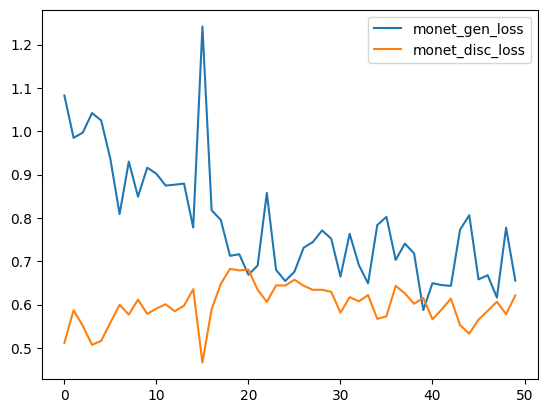

In [17]:
converted = pd.DataFrame()
converted['monet_gen_loss'] = hist_metrics.monet_gen_loss.apply(lambda x: np.mean(x.numpy()))
converted['monet_disc_loss'] = hist_metrics.monet_disc_loss.apply(lambda x: np.mean(x.numpy()))

converted[['monet_gen_loss', 'monet_disc_loss']].plot()


#### We can see that as the epochs increase, the average loss on our generator is (slowly) going down, though it's not a very clean descent. Part of that can be due to the way I'm calculating the value for this graph (it's a bit tricky compared to an out-of-the-box training step in previous projects). 
#### Let's take a look at some of our fake Monets next!

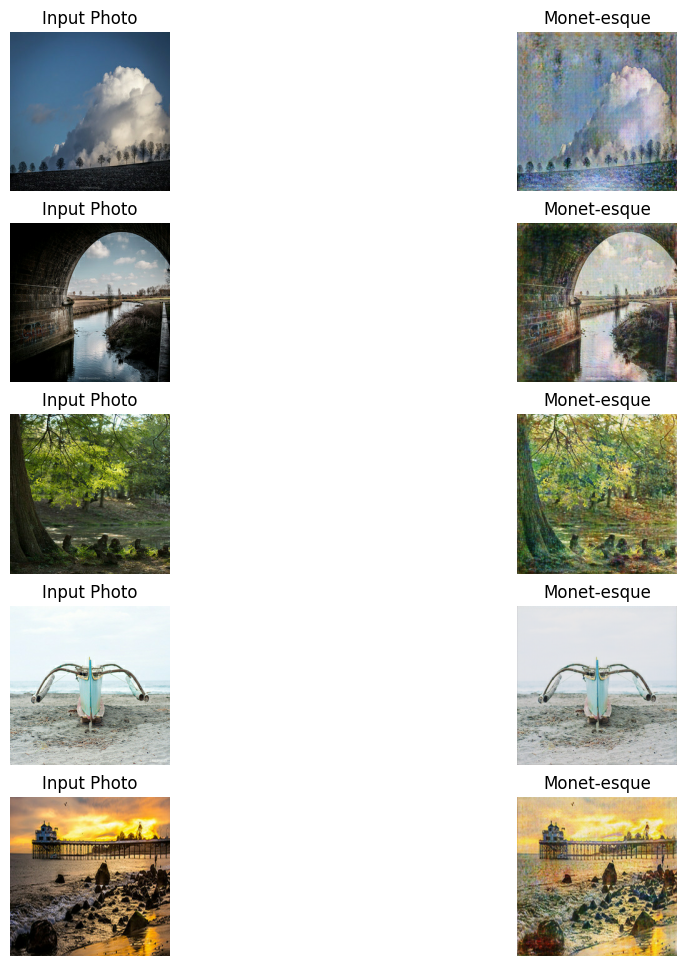

In [18]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

#### It's honestly not very convincing to my human eye, but we'll submit this model and see how it performs.

In [19]:
! mkdir ../images

In [20]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [21]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

#### After submitting to the competition, we ended up with a MiFID of 47.953, which is comparable to some top-performing models! 

# Conclusions

#### This was a very tough assignment, but I was able to learn a lot about CycleGAN and a few different GAN architectures as well! Part of the design process involved deciding what architecture to use for the Generator as that's (arguably) the most important component. After some research, I learned that the most common setups for CycleGAN implementations involve either a UNET Generator or a RESNET Generator. I chose to go with UNET for my architecture as it was already close to the tutorial I was following, and in general seemed a bit easier to understand and implement. In future work I may try and use RESNET instead, but some research suggests that it may not perform as well as other naive CNN-based approaches to generators. 

#### Originally, I submitted a version of this model that was trained in only 25 epochs, and achieved a MiFID of ~70. Doubling the training time led to a fairly impressive increase in performance. The competition limits your run time to 3 hours but it would be worth extending the training time even further -- to 100 or even several hundred epochs. In this case, we might want to add extra pre-processing to avoid overfitting. Some implementations (including the original CycleGAN paper) add random 'jitter' to the input images. This random cropping/flipping helps reduce overfitting and may increase performance over time.

#### While this kernel does not contain any hyperparameter tuning, there are plenty of opportunities to do so. Each layer of the CNNs that upsample or downsample the input images can be tweaked to have fewer filters, or even more. I went with fairly standard values for these hyperparameters and adjusted them as appropriate. One could also experiment with the number of layers in their UNET. By utilizing different strides or paying close attention during upsampling, you can adjust the network to have more downsample/upsample layers, or even fewer if you think the input domain isn't so complicated. One can also tweak the Discriminator. We used a simple CNN but there's plenty of room for tweaking that portion of the GAN to use a more power Discriminator or even a fancier architecture like RESNET.